In [1]:
%matplotlib inline

import fdtd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import tifffile as tf
import os
import time
from fdtd.backend import backend as bd
from skimage.transform import rescale

from matplotlib import animation, rc
from matplotlib.colors import PowerNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

from IPython.display import HTML

#fdtd.set_backend("numpy")
fdtd.set_backend("torch.cuda")

c = 299792458



In [2]:
def efield(grid, z=0):
    return bd.sum(grid.E, -1)[:, :, z]

def onhost(arr):
    if hasattr(arr, 'cpu'):
        return np.array(arr.cpu())
    return arr

def line_source_pointing_at_center(grid, angle=45, length=.2, dist=1):
    # length is fraction of grid height
    # distance is fraction of grid.x//2 from center
    xmid = grid.x/2
    ymid = grid.y/2
    D = dist*xmid
    L = length * grid.x
    sina = np.sin(np.deg2rad(angle))
    cosa = np.cos(np.deg2rad(angle))
    Px = xmid - sina * D
    Py = ymid - cosa * D
    L1x = Px - cosa * L/2
    L1y = Py + sina * L/2
    L2x = Px + cosa * L/2
    L2y = Py - sina * L/2
    return slice(L1x,L2x), slice(L1y,L2y)

def crop_center(img,cropx,cropy, cropz=None):
    if img.ndim == 2:
        y,x = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        return img[starty:starty+cropy,startx:startx+cropx]
    elif img.ndim == 3:
        z,y,x = img.shape
        if not cropz:
            cropz = z
        startz = z//2-(cropz//2)
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        return img[startz:startz+cropz,starty:starty+cropy,startx:startx+cropx]

In [3]:

def simulate_sim(
    total_time=100,
    dt=5,
    pixel=50e-9,
    wave=800e-9,
    angle=14,
    glass_ri = 1.55,
    medium_ri = 1.33,
    width=30e-6,
    height=30e-6,
    line_length=0.3,
    dist=1.3,
    central_amp=1,
    write=False,
    show=True
):

    grid = fdtd.Grid(
        shape = (height, width, 1), # 30µm x 30µm x 1 (grid_spacing) --> 2D FDTD
        grid_spacing = pixel, # 100nm "pixel" size
        permittivity = medium_ri**2,
    )

    s1, s2 = line_source_pointing_at_center(grid, angle=angle, length=line_length, dist=dist)
    grid[s1, s2, 0] = fdtd.LineSource(period=wave/299792458, name="sourceL")
    print(s1)
    print(s2)
    s1, s2 = line_source_pointing_at_center(grid, angle=-angle, length=line_length, dist=dist)
    grid[s1, s2, 0] = fdtd.LineSource(period=wave/299792458, name="sourceR")
    
    s1, s2 = line_source_pointing_at_center(grid, angle=0, length=line_length, dist=dist)
    grid[s1, s2, 0] = fdtd.LineSource(period=wave/299792458, name="sourceC", power=central_amp)
    
#     grid[:height/2, :, 0] = fdtd.Object(permittivity=glass_ri**2, name="coverglass")
#     grid[height/2-0.1e-6:height/2+0.4e-6, 0:width/9.5, 0] = fdtd.Object(permittivity=1e10, name="block")

    # PML
    grid[0:100, :, :] = fdtd.PML(name="pml_xlow")
    grid[-100:, :, :] = fdtd.PML(name="pml_xhigh")
    grid[:, 0:150, :] = fdtd.PML(name="pml_ylow")
    grid[:, -200:, :] = fdtd.PML(name="pml_yhigh")

    if show:
        grid.visualize(z=0)
            
    eout = []
    for t in tqdm(np.arange(0,total_time,dt)):
        grid.run(total_time=dt, progress_bar=False)
        eout.append(onhost(efield(grid, z=0)))
    return eout, grid

/opt/miniconda/envs/gpu/lib/python3.7/site-packages/fdtd/backend.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr, device="cuda", dtype=dtype)


slice(1.2776924864227568e-06, 6.20714389567461e-06, None)
slice(1.3649712436989258e-05, 4.3787627119705255e-06, None)


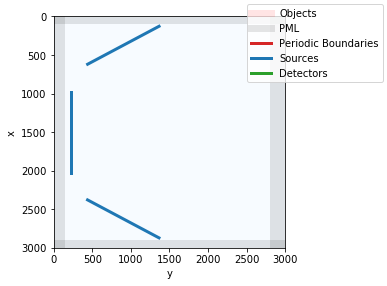

In [4]:
wv = 600e-9
angle=62
eout,grid = simulate_sim(total_time=8000, dt=10, pixel=10e-9, wave=wv, angle=angle, line_length=0.35, dist=0.85, central_amp=1)

In [5]:
eout = np.stack(eout).astype(np.float32)

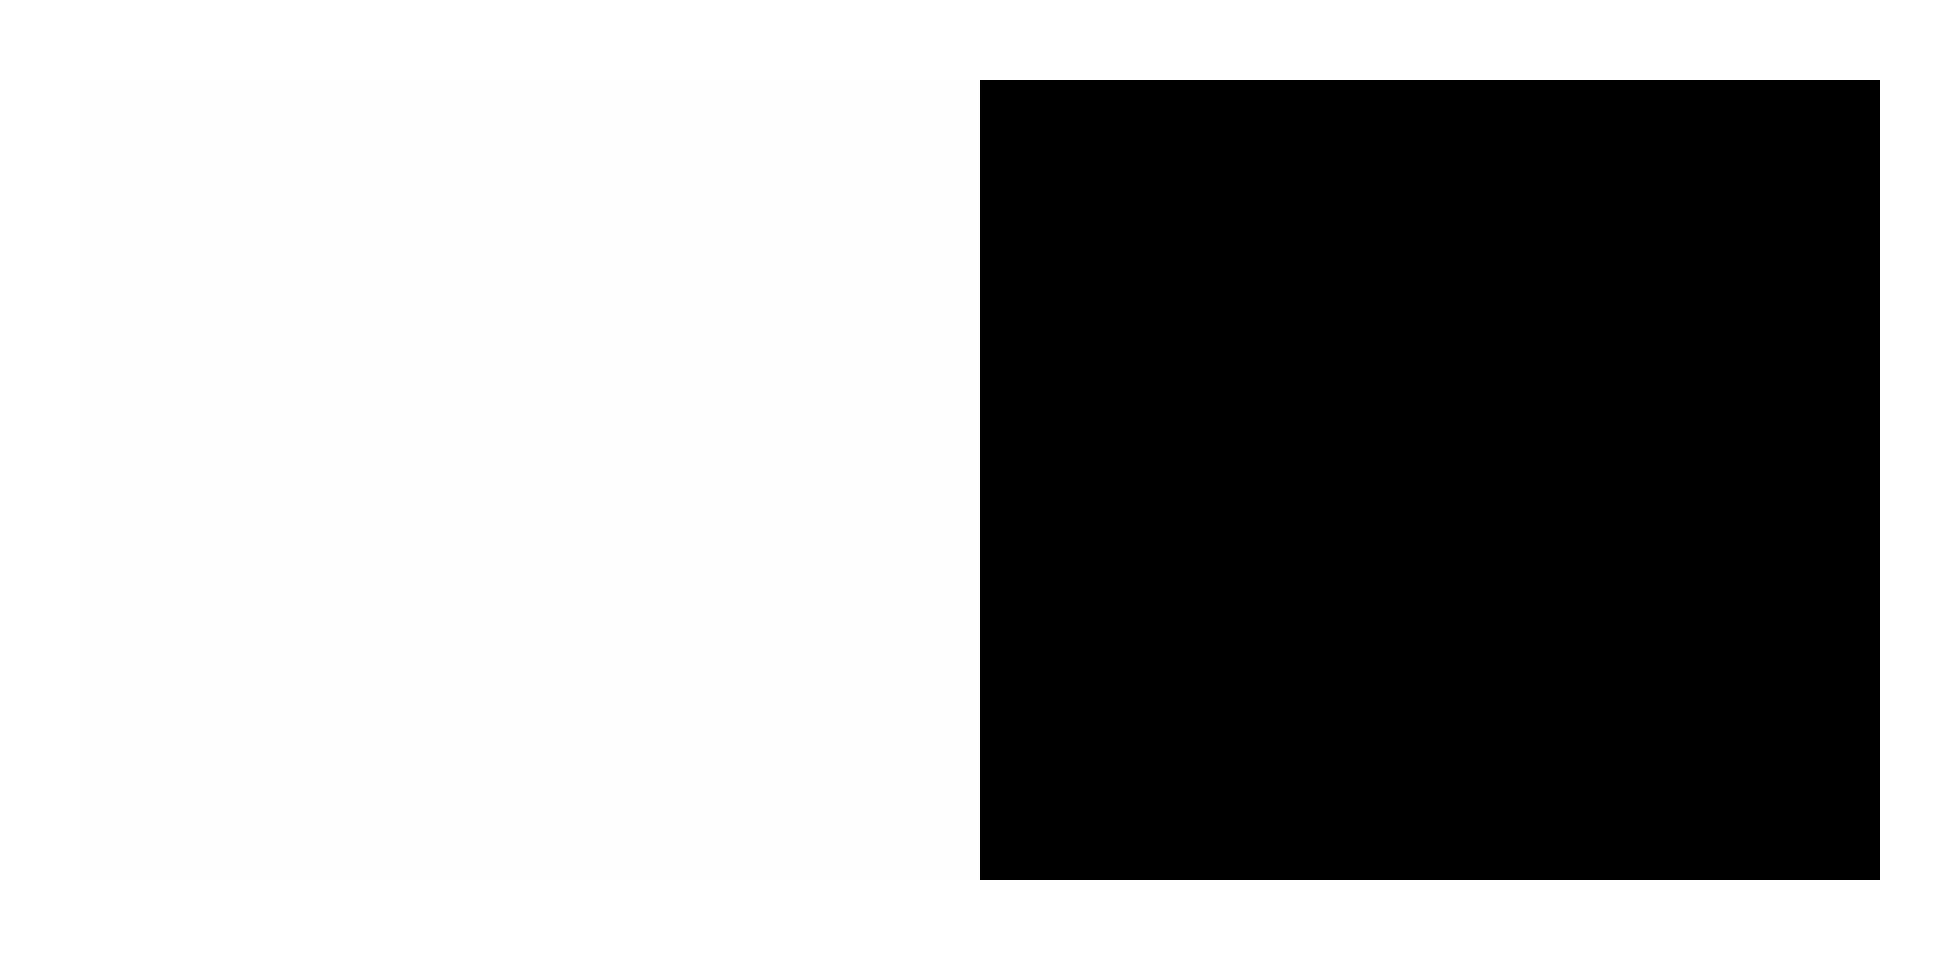

In [16]:
def plot_images(img_list, binsize=16, downsize=1):
    squared = img_list**2
    
    def init():
        im1.set_data(img_list[0])
        im2.set_data(intensity(0))
        return (im1, im2)

    def animate(i):
        im1.set_data(img_list[i])
        im2.set_data(intensity(i))
        return (im1, im2)
    
    def intensity(i):
        if i < binsize:
            i = squared[:i+1].mean(0)
        else:
            i = squared[i-binsize:i+1].mean(0)
        return i

    ratio = np.divide(*img_list.shape[1:])
    fig = plt.figure(frameon=False, figsize=(2/ratio,1), dpi=img_list.shape[1]//downsize)
    ax1 = fig.add_axes([0, 0, .5, 1], label='ax1')
    ax2 = fig.add_axes([.5, 0, .5, 1], label='ax2')
#     fig = plt.figure(frameon=False, figsize=(1, 32/18), dpi=img_list.shape[1]//downsize)
#     ax2 = fig.add_axes([0, 0, 1, .5,], label='ax1')
#     ax1 = fig.add_axes([0, .5, 1, .5,], label='ax2')

    ax1.axis('off')
    ax2.axis('off')
    im1 = ax1.imshow(img_list[0], cmap='bwr', vmin=-0.003, vmax=0.003)
    im2 = ax2.imshow(intensity(0), cmap='cubehelix', norm=PowerNorm(gamma=0.85), vmin=0, vmax=squared[-100:].mean(0).max()*0.95)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=tqdm(range(len(img_list))), interval=100, blit=True)

    return anim

# tf.imsave(f'sim_{int(wv*1e9)}nm_{angle}deg.tif', eout)

# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=20, metadata=dict(artist='Talley Lambert'),
#                 codec="h264", extra_args=['-pix_fmt', 'yuv420p'],
#                 bitrate=2200)

# gifWriter = animation.writers['imagemagick']
# gifWriter = Writer(fps=20, metadata=dict(artist='Talley Lambert'))

anim = plot_images(np.fliplr(np.transpose(crop_center(eout, 1600, 1800), (0,2,1))), downsize=2)
#anim.save(f'sim_{int(wv*1e9)}nm_{angle}deg.mp4', writer=writer)
#anim.save(f'sim_{int(wv*1e9)}nm_{angle}deg.gif', writer=gifWriter)

# HTML(anim.to_html5_video())

In [18]:
anim.save(f'sim_{int(wv*1e9)}nm_{angle}deg.gif', writer='imagemagick', fps=20)

In [19]:

# # Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Talley Lambert'),
                codec="h264", extra_args=['-pix_fmt', 'yuv420p'],
                bitrate=2200)

# anim = plot_images(np.fliplr(np.transpose(crop_center(eout, 1600, 1800), (0,2,1))), downsize=2)
anim.save(f'sim_{int(wv*1e9)}nm_{angle}deg.mp4', writer=writer)



6.284547e-05 -0.0028099974 0.0018833415


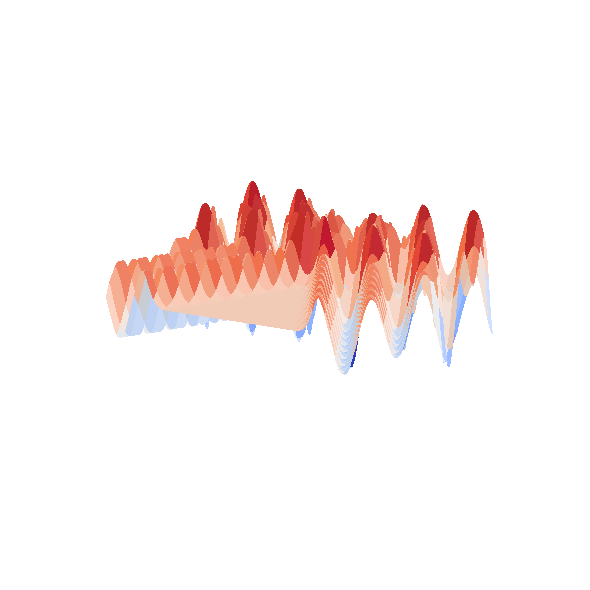

In [158]:


Z = crop_center(eout[240], 256, 256)
print(Z.mean(), Z.min(), Z.max())
light = LightSource(180,45)
illuminated_surface = light.shade(Z, cmap=cm.coolwarm)

X, Y = np.meshgrid(np.arange(Z.shape[0]), np.arange(Z.shape[1]))
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, 
                rstride=10, cstride=10,
                linewidth=0,
                vmin=-0.0028, vmax=0.0028, antialiased=False,
                facecolors=illuminated_surface)
ax.set_zlim(-0.004, 0.004)
ax.set_axis_off()
ax.view_init(elev=15, azim=30)


(256, 256)


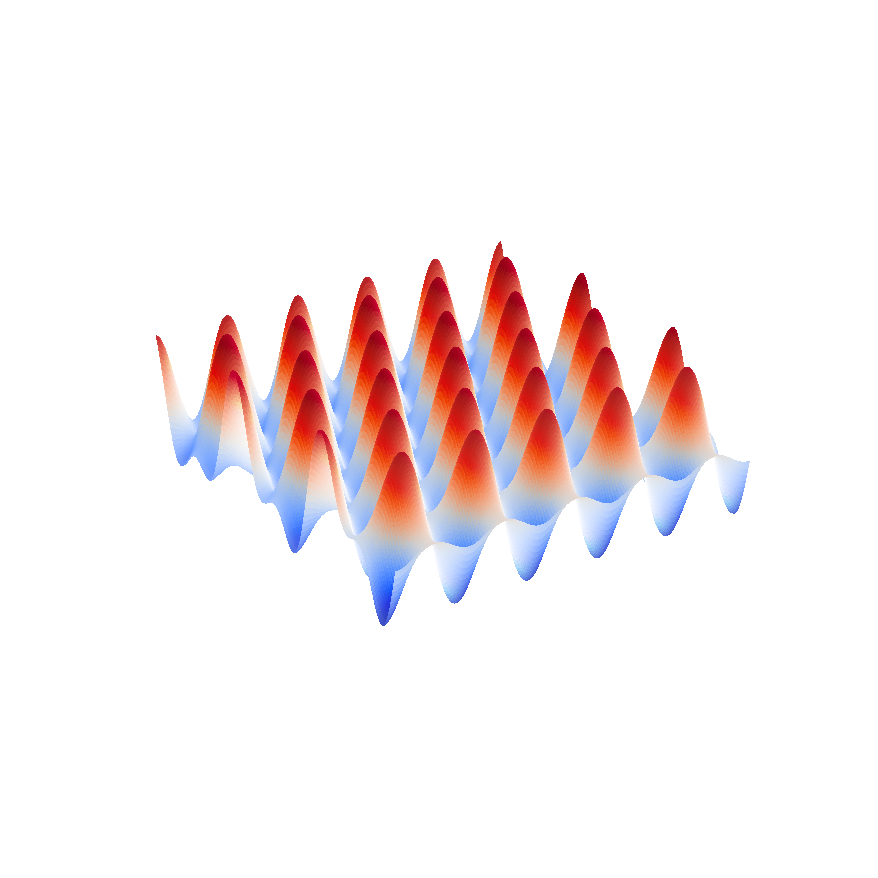

In [187]:
def surfanim(Z, fps=20, stride=10):
    X, Y = np.meshgrid(np.arange(Z.shape[-2]), np.arange(Z.shape[-1]))
    elev = np.linspace(25, 45, len(Z))
    azim = np.linspace(-35, 15, len(Z))
    light_intensity = 0.0025
    zlims = 0.007
    def update(frame):
        plot[0].remove()
        illuminated_surface = light.shade(Z[frame], cmap=cm.coolwarm, vmin=-light_intensity, vmax=light_intensity)
        plot[0] = ax.plot_surface(X, Y, Z[frame], cmap=cm.coolwarm, 
                    rstride=stride, cstride=stride,
                    linewidth=0,
                    vmin=-light_intensity, vmax=light_intensity, antialiased=False,
                    facecolors=illuminated_surface)
        ax.set_zlim(-zlims, zlims)
        ax.view_init(elev=elev[frame], azim=azim[frame])

    print(Z[0].shape)
    light = LightSource(180,45)
    illuminated_surface = light.shade(Z[0], cmap=cm.coolwarm, vmin=-light_intensity, vmax=light_intensity)
    
    fig = plt.figure(figsize=(12,12))
    ax = Axes3D(fig)
    plot = [ax.plot_surface(X, Y, Z[0], cmap=cm.coolwarm, 
                    rstride=stride, cstride=stride,
                    linewidth=0,
                    vmin=-light_intensity, vmax=light_intensity, antialiased=False,
                    facecolors=illuminated_surface)]
    ax.set_zlim(-zlims, zlims)
    ax.set_axis_off()
    anim = animation.FuncAnimation(fig, update,
                                   frames=tqdm(range(len(Z))),
                                   interval=1000/fps)

    return anim

anim = surfanim(crop_center(eout[700:701], 256, 256), stride=1, fps=10)
# HTML(anim.to_html5_video())

anim.save(f'sim_{int(wv*1e9)}nm_{angle}deg_wavesurface_new.gif', writer='imagemagick', fps=10)